<div class=title>
<strong><center><font size="3">DAY 9 - IYKRA</font></center>
<hr>
<center><font size="5"><strong>Self-Practice 3</strong></font></center>
<center><font size="4"><strong>Foundation of Data Engineering</strong></font></center>
<hr>
<p style="text-align:center">Author</p>
<center>Joshua Effendi</center>
<p style="text-align:center">Date:</p>
<center>31 October 2019</center></strong>
</div>

<div class=title1>
    <b><font size='3'>Import Libaries and Set Up Libaries</font></b>
</div>

In [82]:
import csv
import os

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import re, string, unicodedata

from textblob import TextBlob
from textblob import Word

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm 
tqdm.pandas()

from bs4 import BeautifulSoup
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
 
import google.oauth2.credentials

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

from IPython.core.display import HTML

def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joshua.effendi01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class=title1>
    <b><font size='3'>Get Youtube's Comment and Save it to CSV</font></b>
</div>

In [136]:
# The CLIENT_SECRETS_FILE variable specifies the name of a file that contains
# the OAuth 2.0 information for this application, including its client_id and
# client_secret.
CLIENT_SECRETS_FILE = "client_secret.json"
 
# This OAuth 2.0 access scope allows for full read/write access to the
# authenticated user's account and requires requests to use an SSL connection.
SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'
 
 
def get_authenticated_service():
    credentials = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
    #  Check if the credentials are invalid or do not exist
    if not credentials or not credentials.valid:
        # Check if the credentials have expired
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_console()

        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(credentials, token)

    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)
 
 
def get_video_comments(service, **kwargs):
    comments = []
    results = service.commentThreads().list(**kwargs).execute()
 
    while results:
        for item in results['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
 
        # Check if another page exists
        if 'nextPageToken' in results:
            kwargs['pageToken'] = results['nextPageToken']
            results = service.commentThreads().list(**kwargs).execute()
        else:
            break
 
    return comments
 
 
def write_to_csv(comments):
    with open('comments.csv', 'w') as comments_file:
        comments_writer = csv.writer(comments_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        comments_writer.writerow(['Video ID', 'Title', 'COMMENT'])
        for row in comments:
            # convert the tuple to a list and write to the output file
            comments_writer.writerow(list(row))

 
def get_videos(service, **kwargs):
    final_results = []
    results = service.search().list(**kwargs).execute()
 
    i = 0
    max_pages = 3
    while results and i < max_pages:
        final_results.extend(results['items'])
 
        # Check if another page exists
        if 'nextPageToken' in results:
            kwargs['pageToken'] = results['nextPageToken']
            results = service.search().list(**kwargs).execute()
            i += 1
        else:
            break
 
    return final_results
 
 
def search_videos_by_keyword(service, **kwargs):
    results = get_videos(service, **kwargs)
    final_result = []
    for item in results:
        title = item['snippet']['title']
        video_id = item['id']['videoId']
        comments = get_video_comments(service, part='snippet', videoId=video_id, textFormat='plainText')
        # make a tuple consisting of the video id, title, comment and add the result to 
        # the final list
        final_result.extend([(video_id, title, comment) for comment in comments]) 
 
    print(final_result)
    write_to_csv(final_result)
 
if __name__ == '__main__':
    # When running locally, disable OAuthlib's HTTPs verification. When
    # running in production *do not* leave this option enabled.
    os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'
    service = get_authenticated_service()
    keyword = input('Enter a keyword: ')
    search_videos_by_keyword(service, q=keyword, part='id,snippet', eventType='completed', type='video')
 

Enter a keyword: Nuke a City


HttpError: <HttpError 403 when requesting https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&videoId=S81K-NiNrV0&textFormat=plainText&pageToken=QURTSl9pME00aVZ4MEV5UFIwd0t3TEctcklhaXpZQzRGeFE0aXZIZzc5OEprd2RNY2dkM2VzZHk5M2ptRXk4QW9xM0ZLa0k1ODRXTVM2ZEZXcjY0TWZzS2pTSE5qd0MtTXZqTEw0dTZ4bzlKN1cxUmhTTzcwaTUwSmI0M3JiVnhEbFVjTXdWRDd5QmZkaHM%3D&alt=json returned "Daily Limit Exceeded. The quota will be reset at midnight Pacific Time (PT). You may monitor your quota usage and adjust limits in the API Console: https://console.developers.google.com/apis/api/youtube.googleapis.com/quotas?project=23456112772">

<div class=title1>
    <b><font size='3'>Get Data from CSV and Convert it DataFrame and Drop Duplicate</font></b>
</div>

In [137]:
df = pd.read_csv('comments.csv')

In [138]:
df = df[['COMMENT']]
df.head()

,COMMENT
0,+447935454150 lovely girl talk to me xxx﻿
1,I always end up coming back to this song<br />﻿
2,"my sister just received over 6,500 new <a rel=..."
3,Cool﻿
4,Hello I&#39;am from Palastine﻿


<div class=title1>
    <b><font size='3'>Data Pre-Processing</font></b>
</div>

In [139]:
#drop duplicate tweet 
g_unique = set()
for item in df['COMMENT']:
        g_unique.add(item) # ensures the element will only be copied if not already in the set
com_yt = []
for item in g_unique:
    com_yt.append(item)
    com_yt_df = pd.DataFrame(com_yt,columns = ['COMMENT'])

In [140]:
len(com_yt_df)

412

<div class=title1>
    <b><font size='2'>Lower Casing</font></b>
</div>

In [141]:
com_yt_df['COMMENT'] = com_yt_df['COMMENT'].apply(lambda x: " ".join(x.lower() for x in x.split()))
com_yt_df['COMMENT'].head()

0    thumbs up if you think this should have 1 bill...
1                      i like the mmph version better﻿
2                                      love this song﻿
3                               plese subscribe to me﻿
4                     hey, it&#39;s charlie from lost﻿
Name: COMMENT, dtype: object

<div class=title1>
    <b><font size='2'>Punctual Removal</font></b>
</div>

In [142]:
com_yt_df['COMMENT'] = com_yt_df['COMMENT'].str.replace('[^\w\s]','')
com_yt_df.head()

,COMMENT
0,thumbs up if you think this should have 1 bill...
1,i like the mmph version better
2,love this song
3,plese subscribe to me
4,hey it39s charlie from lost


<div class=title1>
    <b><font size='2'>Stopwords Removal</font></b>
</div>

In [143]:
stop = stopwords.words('english')
com_yt_df['COMMENT'] = com_yt_df['COMMENT'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
com_yt_df['COMMENT'].head(10)

0                         thumbs think 1 billion views
1                             like mmph version better
2                                            love song
3                                      plese subscribe
4                               hey it39s charlie lost
5                                   noi hate way u lie
6                              like lyrics music video
7       eminem idol people españa mexico latinoamerica
8    guys check extraordinary website called moneyg...
9                                        favorite song
Name: COMMENT, dtype: object

<div class=title1>
    <b><font size='2'>Frequent Words Removal</font></b>
</div>

In [144]:
freq = pd.Series(' '.join(com_yt_df['COMMENT']).split()).value_counts()[:10]
freq

check        175
like          72
please        71
song          69
love          62
channel       57
subscribe     55
video         55
eminem        54
guys          52
dtype: int64

In [145]:
freq = list(freq.index)
com_yt_df['COMMENT'] = com_yt_df['COMMENT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
com_yt_df['COMMENT'].head()

0    thumbs think 1 billion views
1             mmph version better
2                                
3                           plese
4          hey it39s charlie lost
Name: COMMENT, dtype: object

<div class=title1>
    <b><font size='2'>Rare Words Removal</font></b>
</div>

In [146]:
rare_word = pd.Series(' '.join(com_yt_df['COMMENT']).split()).value_counts()[-10:]
rare_word

mexico                          1
retrieve                        1
taylor                          1
worthless                       1
increase                        1
qiameth                         1
depressed                       1
growing                         1
professor                       1
niko20130926t220043613000hey    1
dtype: int64

In [147]:
rare_word = list(rare_word.index)
com_yt_df['COMMENT'] = com_yt_df['COMMENT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
com_yt_df['COMMENT'].head()

0    thumbs think 1 billion views
1             mmph version better
2                                
3                           plese
4          hey it39s charlie lost
Name: COMMENT, dtype: object

<div class=title1>
    <b><font size='2'>Spelling Correction</font></b>
</div>

In [148]:
com_yt_df['COMMENT'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    thumbs think 1 billion views
1             much version better
2                                
3                          please
4            hey its charlie lost
Name: COMMENT, dtype: object

<div class=title1>
    <b><font size='2'>Tokenization</font></b>
</div>

In [149]:
TextBlob(com_yt_df['COMMENT'][1]).words

WordList(['mmph', 'version', 'better'])

<div class=title1>
    <b><font size='2'>Stemming</font></b>
</div>

In [150]:
st = PorterStemmer()
com_yt_df['COMMENT'] = com_yt_df['COMMENT'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

<div class=title1>
    <b><font size='2'>Lematization</font></b>
</div>

In [151]:
com_yt_df['COMMENT'] = com_yt_df['COMMENT'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
com_yt_df['COMMENT'].head()

0    thumb think 1 billion view
1           mmph version better
2                              
3                         plese
4          hey it39 charli lost
Name: COMMENT, dtype: object

<div class=title1>
    <b><font size='3'>Data Exploration</font></b>
</div>

<div class=title1>
    <b><font size='2'>Words Count</font></b>
</div>

In [152]:
com_yt_df['word_count'] = com_yt_df['COMMENT'].apply(lambda x: len(str(x).split(" ")))
com_yt_df.head()

,COMMENT,word_count
0,thumb think 1 billion view,5
1,mmph version better,3
2,,1
3,plese,1
4,hey it39 charli lost,4


<div class=title1>
    <b><font size='2'>Character Count</font></b>
</div>

In [153]:
com_yt_df['char_count'] = com_yt_df['COMMENT'].str.len()
com_yt_df.head()

,COMMENT,word_count,char_count
0,thumb think 1 billion view,5,26
1,mmph version better,3,19
2,,1,0
3,plese,1,5
4,hey it39 charli lost,4,20


<div class=title1>
    <b><font size='2'>Stopwords Count</font></b>
</div>

In [154]:
stop = stopwords.words('english')
com_yt_df['stopwords'] = com_yt_df['COMMENT'].apply(lambda x: len([x for x in x.split() if x in stop]))
com_yt_df.head()

,COMMENT,word_count,char_count,stopwords
0,thumb think 1 billion view,5,26,0
1,mmph version better,3,19,0
2,,1,0,0
3,plese,1,5,0
4,hey it39 charli lost,4,20,0


<div class=title1>
    <b><font size='2'>Special Characters Count</font></b>
</div>

In [155]:
com_yt_df['spec_char'] = com_yt_df['COMMENT'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
com_yt_df.head()

,COMMENT,word_count,char_count,stopwords,spec_char
0,thumb think 1 billion view,5,26,0,0
1,mmph version better,3,19,0,0
2,,1,0,0,0
3,plese,1,5,0,0
4,hey it39 charli lost,4,20,0,0


<div class=title1>
    <b><font size='3'>Labeling</font></b>
</div>

In [156]:
new_df = df.copy()
new_df.head()
text = new_df.COMMENT

In [157]:
for i in range(0,len(text)):
    textB = TextBlob(text[i])
    sentiment = textB.sentiment.polarity
    new_df.set_value(i,'sentiment', sentiment)
    if sentiment < 0.00 :
        sentimentclass = 'Negative'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    elif sentiment > 0.00 :
        sentimentclass = 'Positive'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    else :
        sentimentclass = ' Netral'
        new_df.set_value(i, 'sentimentclass', sentimentclass)

In [158]:
new_df = new_df[['COMMENT','sentiment','sentimentclass']]
new_df

,COMMENT,sentiment,sentimentclass
0,+447935454150 lovely girl talk to me xxx﻿,0.500000,Positive
1,I always end up coming back to this song<br />﻿,0.000000,Netral
2,"my sister just received over 6,500 new <a rel=...",0.140693,Positive
3,Cool﻿,0.000000,Netral
4,Hello I&#39;am from Palastine﻿,0.000000,Netral
...,...,...,...
443,SUBSCRIBE TO MY CHANNEL X PLEASE!. SPARE,0.000000,Netral
444,Check out my videos guy! :) Hope you guys had ...,0.625000,Positive
445,3 yrs ago I had a health scare but thankfully ...,0.124362,Positive
446,Rihanna looks so beautiful with red hair ;)﻿,0.366667,Positive


<div class=title1>
    <b><font size='3'>Aggregation of SentimentClass</font></b>
</div>

In [159]:
#count sentiment 
sentiment = new_df.groupby(['sentimentclass'])['sentimentclass'].count()

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['sentimentclass']
chart.drop(['sentimentclass'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,sentimentclass,tweet_count,percent
0,Netral,185,0.412946
1,Negative,31,0.069196
2,Positive,232,0.517857


<div class=title1>
    <b><font size='3'>Visualization</font></b>
</div>

<div class=title1>
    <b><font size='2'>Bar Chart/font></b>
</div>

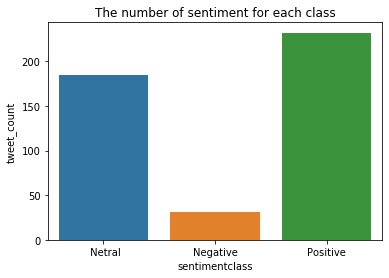

In [160]:
#make a barchar
ax = sns.barplot(x= 'sentimentclass', y='tweet_count', data=chart)
ax = ax.set_title('The number of sentiment for each class') 

<div class=title1>
    <b><font size='2'>Pie Chart</font></b>
</div>

(-1.1100616326353163,
 1.1009182166409737,
 -1.2249019427552508,
 1.1125459637720465)

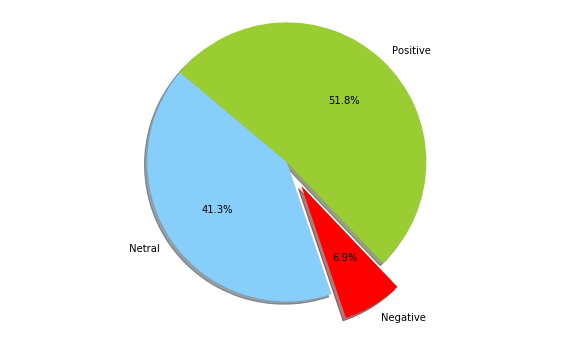

In [161]:
colors = [ 'lightskyblue','red','yellowgreen']
explode = (0, 0.2, 0)  # explode 1st slice
# Plot
figure = plt.figure(figsize= (10,6))
plt.pie(chart['tweet_count'], explode=explode, labels=chart['sentimentclass'], colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

<div class=title1>
    <b><font size='3'>Data Preparation</font></b>
</div>

In [162]:
new_df_c = new_df[['COMMENT','sentimentclass']]

In [163]:
new_df_c

,COMMENT,sentimentclass
0,+447935454150 lovely girl talk to me xxx﻿,Positive
1,I always end up coming back to this song<br />﻿,Netral
2,"my sister just received over 6,500 new <a rel=...",Positive
3,Cool﻿,Netral
4,Hello I&#39;am from Palastine﻿,Netral
...,...,...
443,SUBSCRIBE TO MY CHANNEL X PLEASE!. SPARE,Netral
444,Check out my videos guy! :) Hope you guys had ...,Positive
445,3 yrs ago I had a health scare but thankfully ...,Positive
446,Rihanna looks so beautiful with red hair ;)﻿,Positive


<div class=title1>
    <b><font size='3'>Data Pre-Processing</font></b>
</div>

<div class=title1>
    <b><font size='2'>Pre-Processing</font></b>
</div>

In [164]:
stop = stopwords.words('english')
new_df_c['COMMENT'] = new_df_c['COMMENT'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [165]:
#lematization 
new_df_c['COMMENT']  = new_df_c['COMMENT'] .apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

<div class=title1>
    <b><font size='2'>Data Exploration</font></b>
</div>

In [166]:
#count sentiment 
sentiment = new_df_c.groupby(['sentimentclass'])['sentimentclass'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['sentimentclass']
chart.drop(['sentimentclass'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,sentimentclass,tweet_count,percent
0,Netral,185,0.412946
1,Negative,31,0.069196
2,Positive,232,0.517857


<div class=title1>
    <b><font size='3'>Feature Extraction</font></b>
</div>

<div class=title1>
    <b><font size='2'>Count Vectorizer</font></b>
</div>

In [167]:
count_vectorizer = CountVectorizer(stop_words='english')

<div class=title1>
    <b><font size='2'>TF-IDF Vectorizer</font></b>
</div>

In [168]:
tfidf = TfidfVectorizer(stop_words='english')

<div class=title1>
    <b><font size='3'>Modeling</font></b>
</div>

<div class=title1>
    <b><font size='2'>Train-Test Split</font></b>
</div>

In [169]:
X = new_df_c['COMMENT']
y = new_df_c['sentimentclass']

In [170]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

<div class=title1>
    <b><font size='2'>Machine Learning - Logistic Regression</font></b>
</div>

In [171]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

<div class=title1>
    <b><font size='2'>Machine Learning - Logistic Regression - Evaluation</font></b>
</div>

In [172]:
# using count vectorizer
print("______________ Countvectorizer ______________")

# Lr_clf_vec_report_train = classification_report(train_y, Lr_pred_vect_train)
# Lr_clf_vec_report_test = classification_report(test_y, Lr_pred_vect_test)

# Lr_confmatrix_vect_train = confusion_matrix(train_y, Lr_pred_vect_train) 
# Lr_confmatrix_vect_test = confusion_matrix(test_y, Lr_pred_vect_test)

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Information :')
# print('Confusion matrix for Train :')
# print(Lr_confmatrix_vect_train,'\n')
# print('Confusion matrix for Test :')
# print(Lr_confmatrix_vect_test,'\n')
# print('Classification Refort for Train :')
# print(Lr_clf_vec_report_train,'\n')
# print('Classification Refort for Test :')
# print(Lr_clf_vec_report_test,'\n')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 93.85% & 77.78%
Precision train & test  : 93.85% & 77.78%
F1 Score train & test   : 93.85% & 77.78%


In [173]:
# using count vectorizer
print("______________ TF-IDF ______________")


Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 86.59% & 63.33%
Precision train & test  : 86.59% & 63.33%
F1 Score train & test   : 86.59% & 77.78%
